In [1]:
import random, os, re, multiprocessing, nltk, gc
from tabulate import tabulate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
import ast

In [2]:
#df = pd.read_csv('Bert_tkn.csv')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# df['input_ids'] = df['input_ids'].apply(ast.literal_eval)
# df['attention_mask'] = df['attention_mask'].apply(ast.literal_eval)

In [5]:
# input_ids = torch.tensor(df['input_ids'].tolist())
# attention_masks = torch.tensor(df['attention_mask'].tolist())
# labels = torch.tensor(df['label'].tolist())

In [6]:
# torch.save((input_ids, attention_masks, labels), 'tokenized_Bert_data.pt')

In [13]:
input_ids, attention_masks, labels = torch.load('bert_500k_balanced.pt')

In [8]:
ai_indices = (labels == 1).nonzero(as_tuple=True)[0]
human_indices = (labels == 0).nonzero(as_tuple=True)[0]

In [9]:
# Randomly select 250k from each class
selected_ai = ai_indices[torch.randperm(len(ai_indices))[:250_000]]
selected_human = human_indices[torch.randperm(len(human_indices))[:250_000]]

In [10]:
# Concatenate selected indices
selected_indices = torch.cat([selected_ai, selected_human])
selected_indices = selected_indices[torch.randperm(len(selected_indices))]  # Shuffle full dataset

In [11]:
# Subset the tensors
input_ids_small = input_ids[selected_indices]
attention_masks_small = attention_masks[selected_indices]
labels_small = labels[selected_indices]

In [12]:
# Optionally save this subset
torch.save((input_ids_small, attention_masks_small, labels_small), 'bert_500k_balanced.pt')

In [14]:
X_train_ids, X_val_ids, X_train_mask, X_val_mask, y_train, y_val = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, random_state=42
)

In [15]:
train_dataset = TensorDataset(X_train_ids, X_train_mask, y_train)
val_dataset = TensorDataset(X_val_ids, X_val_mask, y_val)

In [16]:
batch_size = 16
train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_loader = DataLoader(val_dataset, sampler=RandomSampler(val_dataset), batch_size=batch_size)

In [17]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [18]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 3
)

In [19]:
# Training function (runs one chunk at a time)
def train_in_chunks(model, train_loader, val_loader, chunk_size=100_000, epochs=1):
    history = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        total_loss, y_preds, y_true = 0, [], []

        for i, batch in enumerate(tqdm(train_loader, desc="Training")):
            b_input_ids, b_mask, b_labels = [x.to(device) for x in batch]
            model.zero_grad()

            outputs = model(b_input_ids, attention_mask=b_mask, labels=b_labels)
            loss, logits = outputs.loss, outputs.logits

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            labels_cpu = b_labels.cpu().numpy()
            y_preds.extend(preds)
            y_true.extend(labels_cpu)
            total_loss += loss.item()

        train_acc = accuracy_score(y_true, y_preds)
        val_loss, val_acc = evaluate(model, val_loader)
        history.append({'train_loss': total_loss / len(train_loader), 'train_acc': train_acc,
                        'val_loss': val_loss, 'val_acc': val_acc})
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return history

In [20]:
# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    total_loss, y_preds, y_true = 0, [], []

    for batch in tqdm(dataloader, desc="Evaluating"):
        b_input_ids, b_mask, b_labels = [x.to(device) for x in batch]

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_mask, labels=b_labels)
            loss, logits = outputs.loss, outputs.logits

        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        labels = b_labels.cpu().numpy()
        total_loss += loss.item()
        y_preds.extend(preds)
        y_true.extend(labels)

    acc = accuracy_score(y_true, y_preds)
    return total_loss / len(dataloader), acc

In [21]:
# Train the model
history = train_in_chunks(model, train_loader, val_loader, epochs=3)


Epoch 1/3


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 6250/6250 [28:35<00:00,  3.64it/s]


Train Acc: 0.9470 | Val Acc: 0.9384

Epoch 2/3


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 6250/6250 [28:30<00:00,  3.65it/s]


Train Acc: 0.9798 | Val Acc: 0.9509

Epoch 3/3


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 6250/6250 [28:36<00:00,  3.64it/s]

Train Acc: 0.9931 | Val Acc: 0.9556


In [22]:
# Save model
torch.save(model.state_dict(), 'bert_finetuned_downsampled.pt')

In [23]:
# Evaluate and print final report
model.eval()
all_preds, all_labels = [], []
for batch in val_loader:
    b_input_ids, b_mask, b_labels = [x.to(device) for x in batch]
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_mask)
    preds = torch.argmax(outputs.logits, dim=1).detach().cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(b_labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     50151
           1       0.95      0.96      0.96     49849

    accuracy                           0.96    100000
   macro avg       0.96      0.96      0.96    100000
weighted avg       0.96      0.96      0.96    100000



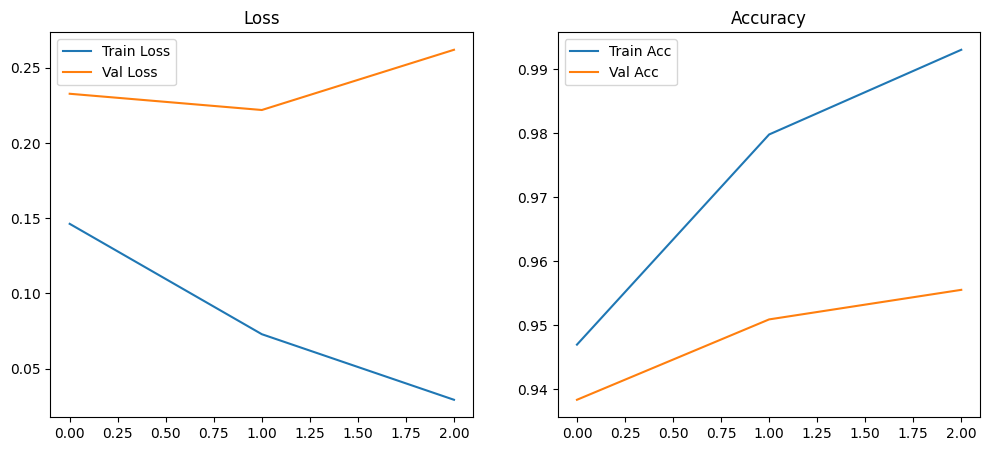

In [25]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([x['train_loss'] for x in history], label='Train Loss')
plt.plot([x['val_loss'] for x in history], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.savefig("LOSS_Bert.png")

plt.subplot(1, 2, 2)
plt.plot([x['train_acc'] for x in history], label='Train Acc')
plt.plot([x['val_acc'] for x in history], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.savefig("ACCURACY_Bert.png")

plt.show()
